<center><h4> This data-challenge was created for the data-camp course of the Master 2 Data-Science of Université Évry (Paris-Saclay) </h4></center>

# Introduction 

Biologically, [it is known that](https://www.ncbi.nlm.nih.gov/books/NBK26885/), while cells carry (almost) the same genomic information, they tend to *express* only a fraction of their genes leading to specialization into specific *types* with different biological functions. Thus, cell-types study and classification is of primary interest for many biological and medical applications. In the past decade, measuring genes expression level at the scale of a unique cell has become possible with the rise of high-throughput technologies named single-cell RNA-seq (scRNA-seq).

The goal of this data challenge is the **supervised** classification of cell-types thanks to the **scMARK** benchmark dataset from [Mendonca et. al](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1). The authors compiled 100, 000 cells expression from 10 different studies to serve as a comparison for different machine learning approaches, in an analogy with the MNIST benchmark dataset for computer vision. 

This data-challenge uses a small extraction with only 4 cell-types (the labels to predict) from **scMARK**:

    1. Cancer_cells
    2. NK_cells
    3. T_cells_CD4+
    4. T_cells_CD8+
    
The public dataset contains 1500 points splitted in 1000 training points and 500 test points. It will serve as your local benchmark for developing your submissions. On the server side, your submission will use the whole 1500 public points as the training set, and another **private and unavailable test** dataset, containing 1500 supplementary test points, will be used for the ranking of participants. The labels' distribution in the public (resp. private) training and testing datasets are the same.

# Setup 

If marked as `code`, the two following cells will 

* install the required package dependencies
* download the public data on OSF

They are disabled by default since you only have to call these command once (in your dedicated Python env). You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.

<div class="alert alert-block alert-info">
<b>Info:</b> Due to the structure of the challenge, libraries not included in `requirements.txt` will need to be added via a pull request to the <a href=https://github.com/ramp-kits/scMARK_classification> GitHub repo </a>.
</div> 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from problem import get_train_data, get_test_data
from sklearn.decomposition import PCA

In [ ]:

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [ ]:
X_train.toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### A first look at the data


In [ ]:
total_genes_counts = X_train.toarray().sum(axis=0)
total_cell_counts = X_train.toarray().sum(axis=1)

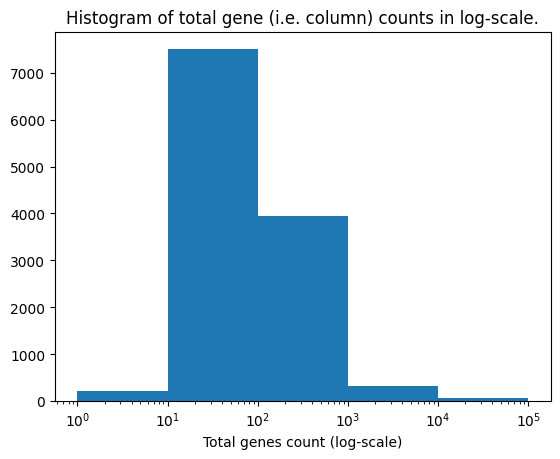

In [ ]:
# plt.hist(np.log10(total_genes_counts), bins = np.arange(6))
plt.hist(total_genes_counts, bins = 10**np.arange(6))
plt.xscale("log")
plt.title("Histogram of total gene (i.e. column) counts in log-scale.")
plt.xlabel('Total genes count (log-scale)')
plt.show()

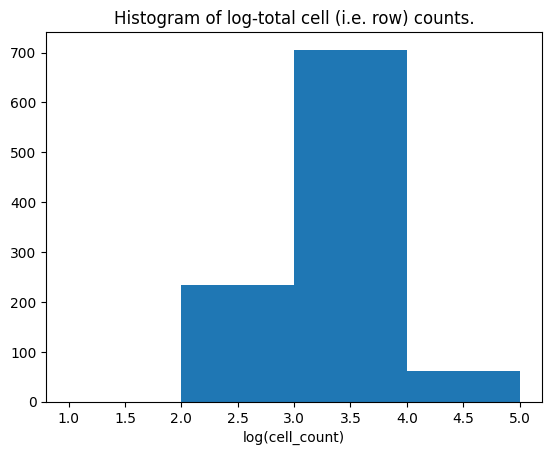

In [ ]:
plt.hist(np.log10(total_cell_counts), bins = np.arange(1,6))
plt.title("Histogram of log-total cell (i.e. row) counts.")
plt.xlabel('log(cell_count)')
plt.show()

In [ ]:
# Convert to DataFrame
x_train = pd.DataFrame(X_train.toarray())
x_test = pd.DataFrame(X_test.toarray())
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,12022,12023,12024,12025,12026,12027,12028,12029,12030,12031
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
classes = y_train.categories
print(classes)
annotation ={} 
for i, cls in enumerate(classes):
    annotation[i] = cls
print(annotation)

Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object')
{0: 'Cancer_cells', 1: 'NK_cells', 2: 'T_cells_CD4+', 3: 'T_cells_CD8+'}


0. Cancer_cells
1. NK_cells
2. T_cells_CD4+
3. T_cells_CD8+


In [ ]:
# Annotation des classes
y_train_encoded = y_train.codes
y_test_encoded = y_test.codes
y_train = pd.Series(y_train_encoded)
y_test = pd.Series(y_test_encoded)

y_train.head()

0    2
1    2
2    2
3    2
4    3
dtype: int8

{'classes': Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object'), 'occurrences': 3    342
2    336
0    237
1     85
Name: count, dtype: int64}


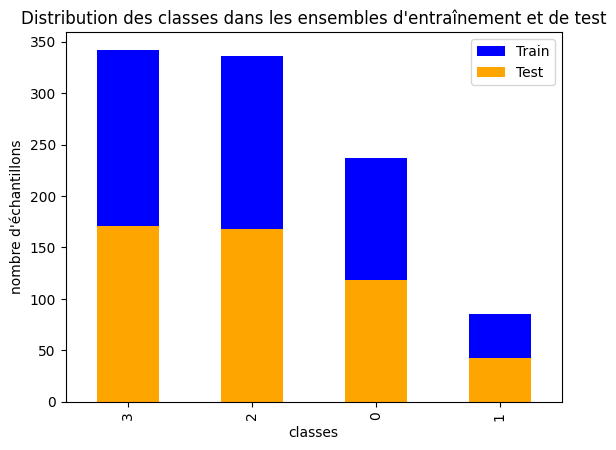

In [ ]:
# Exploration des données

## Distribution des classes 
Occurence_train = {}
Occurence_train["classes"] = classes
Occurence_train["occurrences"] = y_train.value_counts()
print(Occurence_train)

y_train.value_counts().plot(kind='bar', color='blue')
y_test.value_counts().plot(kind='bar', color='orange')
plt.xlabel('classes')
plt.ylabel('nombre d\'échantillons')
plt.title('Distribution des classes dans les ensembles d\'entraînement et de test')
plt.legend(['Train','Test'])


Mon premier essai était d'explorer les données et d'essayer de savoir les gènes importantes pour chaque cellule. Le problème c'est que j'ai fait l'exploration sans normalization et jugé que la moitié des gènes ne sont pas assez représentatives pour la majorité des cellules. Les résultats sont dans les diagrammes au-dessous. 
L'idée derrière est aussi le fait d'ajouter des données pour les la classes 1 en se basant sur la distribution de chaque gène dans les cellules détectées cell_1. 

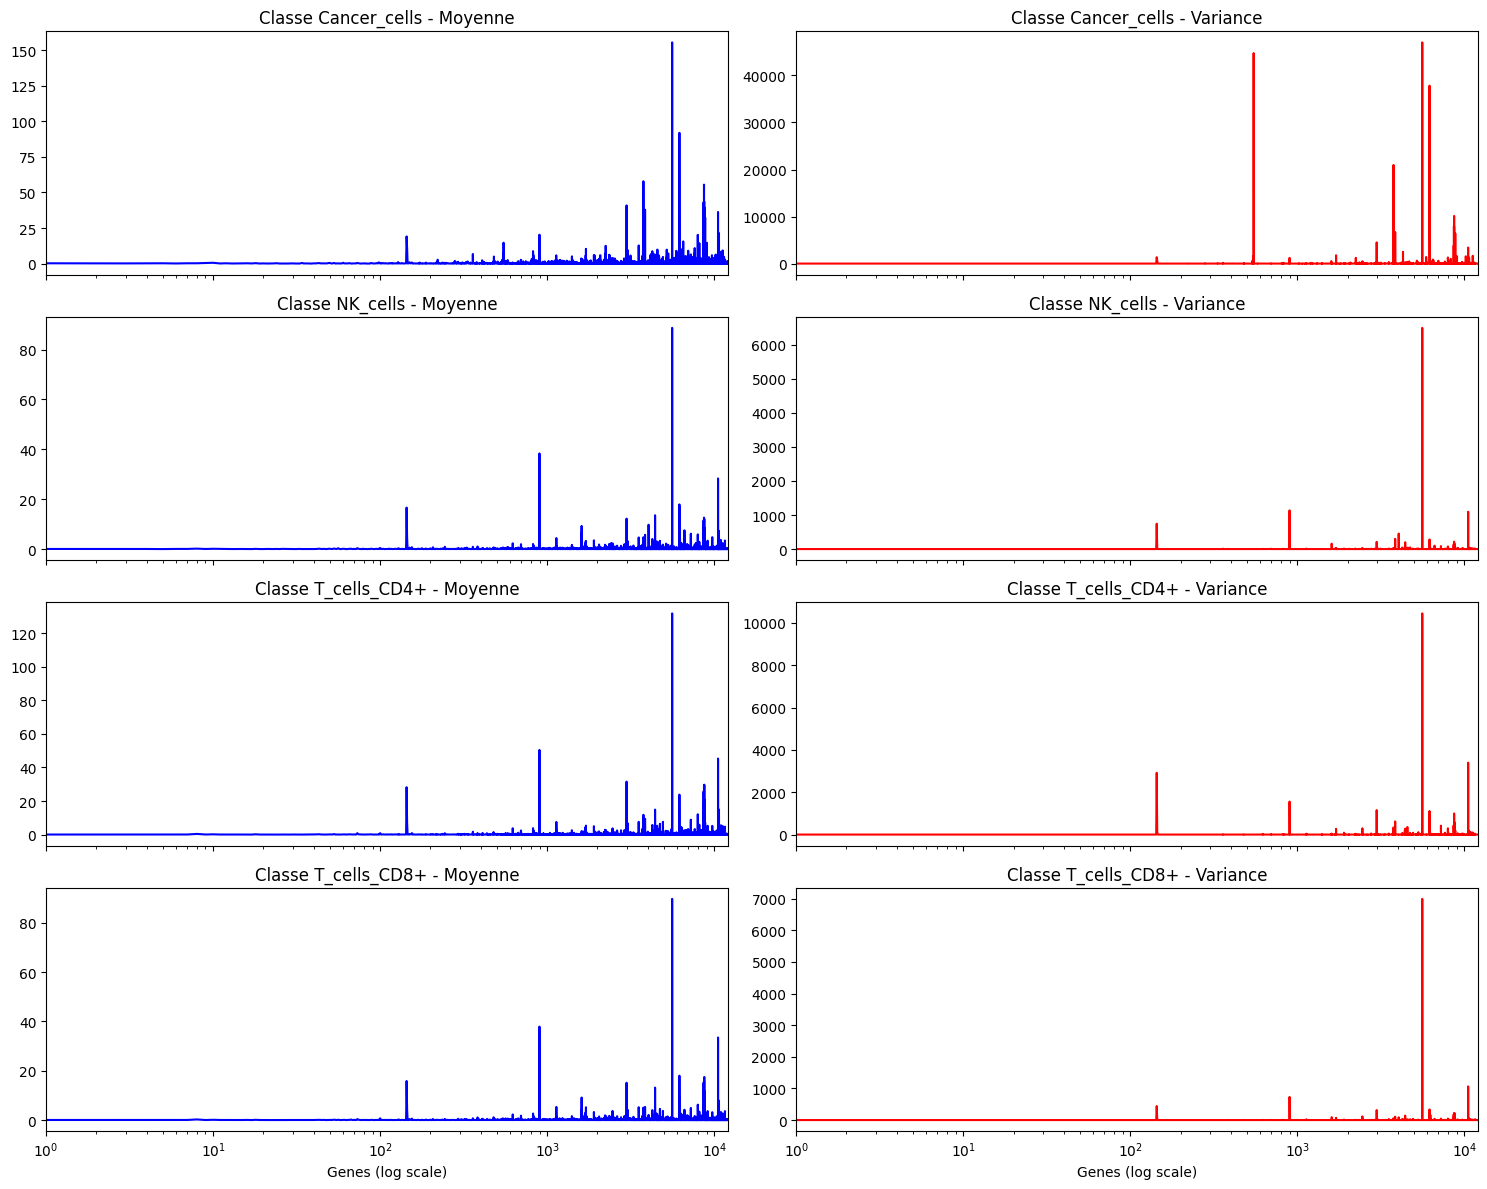

In [ ]:
classes = np.unique(y_train)
n_classes = len(classes)
n_genes = X_train.shape[1]

fig, axes = plt.subplots(n_classes, 2, figsize=(15, 3*n_classes), sharex=True)

for idx, cls in enumerate(classes):
    gene_values = X_train[y_train == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convertir sparse -> dense si nécessaire
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    # Moyenne et variance par gène
    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    # Plot moyenne
    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes])

    # Plot variance
    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes])

# Label commun pour l'axe des x
for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()


A partir des digrammes précedants, on remarque qu'environ la moitié  des gènes ( de 0 à 10^2) ne sont pas assez représntatives pour toutes les classes. 
Nous procédons à la suppression des gènes les moins representatifs

In [ ]:
import numpy as np
from scipy.sparse import issparse

def remove_genes(X, threshold=0.2):
    """
    Supprime les gènes dont la variance est inférieure à un seuil.

    Args:
        X (np.ndarray ou csr_matrix): matrice cellules x gènes
        threshold (float): seuil minimal de variance

    Returns:
        X_filtered: matrice filtrée (mêmes type que X)
        kept_idx: indices des gènes conservés
    """
    if issparse(X):
        # variance = mean(x^2) - mean(x)^2
        mean = np.array(X.mean(axis=0)).ravel()
        mean_sq = np.array(X.multiply(X).mean(axis=0)).ravel()
        var = mean_sq - mean**2
    else:
        var = X.var(axis=0)

    # indices des gènes à garder
    kept_idx = np.where(var >= threshold)[0]

    # filtrer X
    if issparse(X):
        X_filtered = X[:, kept_idx]
    else:
        X_filtered = X[:, kept_idx]

    return X_filtered, kept_idx
X_train, kept_genes_idx = remove_genes(X_train, threshold=0.01)

**Normalisation**
Maintenant je vais essayer de normaliser les données de x_train et les nommer x_train_normalized.

La question qui se pose: pourquoi appliquer une normalisation ? 
 
 - *Correction de la profondeur de séquençage* : Chaque échantillon peut avoir un nombre total de lectures très différent. Sans normalisation, les différences reflètent surtout la quantité totale de séquençage et non l’expression réelle.
 - *Stabilisation de la variance* : Les gènes peu exprimés ont une variance très élevée relative à leur moyenne. Les gènes très exprimés dominent les analyses multivariées (PCA, clustering).
 - *Comparabilité entre échantillons* : Permet de comparer les niveaux d’expression entre échantillons et conditions.

 


In [ ]:
import numpy as np



def preprocess_X(X, method=None):
    """
    Preprocess an RNA-seq expression matrix.
    
    Parameters
    ----------
    X : np.ndarray or scipy.sparse matrix
        Input expression matrix (cells x genes)
    method : str or None
        Type of normalization:
        - None : return X as is
        - "log" : log1p transform
        - "library_size" : normalize each cell by total counts (library size) then log1p
    
    Returns
    -------
    X_processed : np.ndarray
        Preprocessed expression matrix
    """
    # Convert sparse to dense if needed
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    X_processed = X.copy()
    
    if method is None:
        return X_processed
    
    if method == "simple_normalize":
        return X / X.sum(axis=1)[:, np.newaxis]
    
    elif method == "log":
        X_processed = np.log1p(X_processed)
        return X_processed
    
    elif method == "library_size":
        # compute total counts per cell
        library_size = X_processed.sum(axis=1)[:, None]
        # avoid division by zero
        library_size[library_size == 0] = 1
        # normalize
        X_processed = X_processed / library_size * 1e4
        # log1p transform
        X_processed = np.log1p(X_processed)
        return X_processed
    
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")

preprocessing_method = "library_size"
X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)


Niveau d'expression des gènes

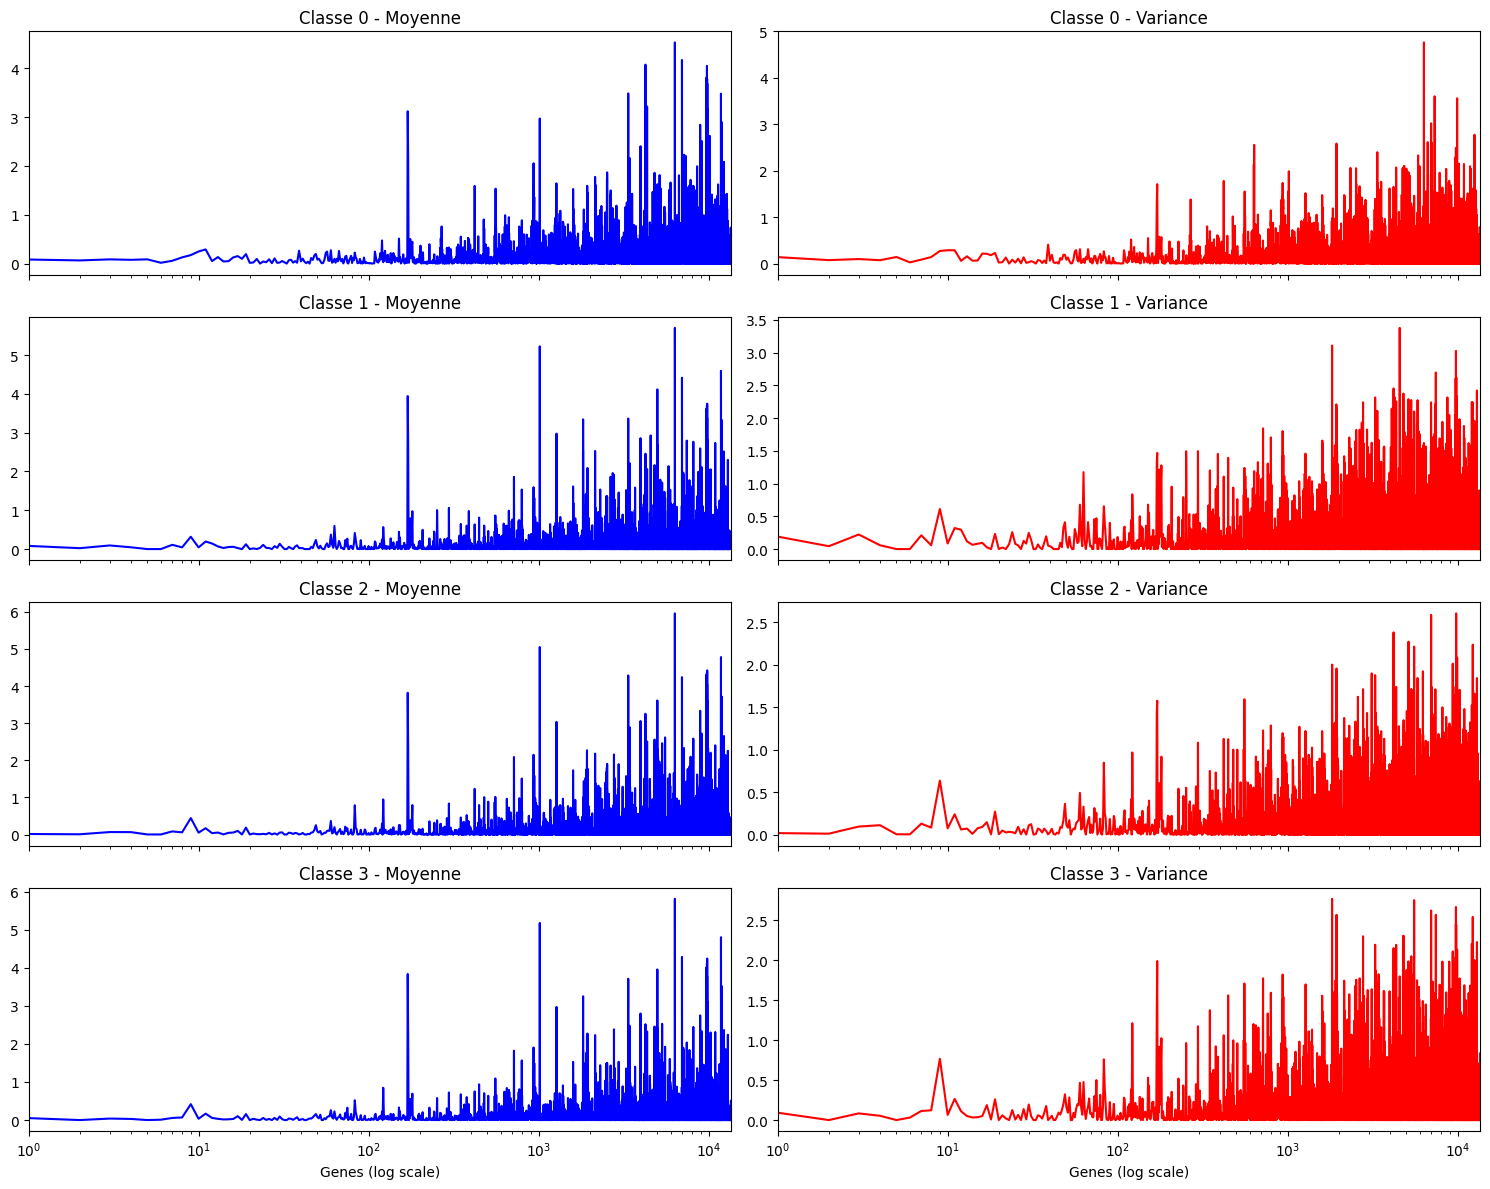

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Assuming X_train_norm and y_train are available from previous cells
classes = np.unique(y_train)
n_classes = len(classes)
n_genes = X_train_norm.shape[1]

fig, axes = plt.subplots(n_classes, 2, figsize=(15, 3*n_classes), sharex=True)

for idx, cls in enumerate(classes):
    gene_values = X_train_norm[y_train == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convertir sparse -> dense si nécessaire
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    # Moyenne et variance par gène
    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    # Plot moyenne
    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes])

    # Plot variance
    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes])

# Label commun pour l'axe des x
for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()

# ACP

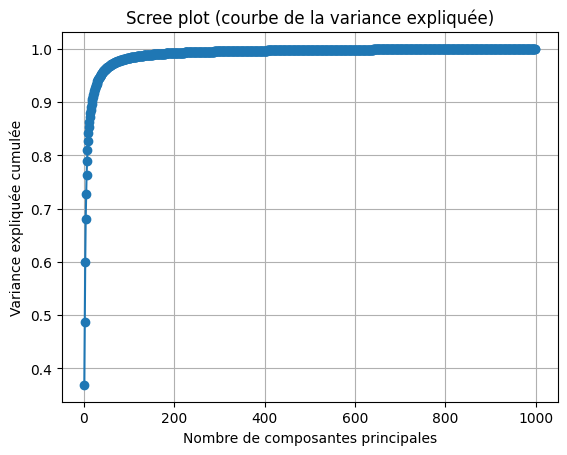

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# On entraîne le PCA
pca = PCA().fit(X_train)

# On trace la variance expliquée cumulée
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Scree plot (courbe de la variance expliquée)')
plt.grid(True)
plt.show()

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# On entraîne le PCA
pca = PCA().fit(X_train_norm)

# On trace la variance expliquée cumulée
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Scree plot (courbe de la variance expliquée)')
plt.grid(True)
plt.show()

Test for number of features for PCA

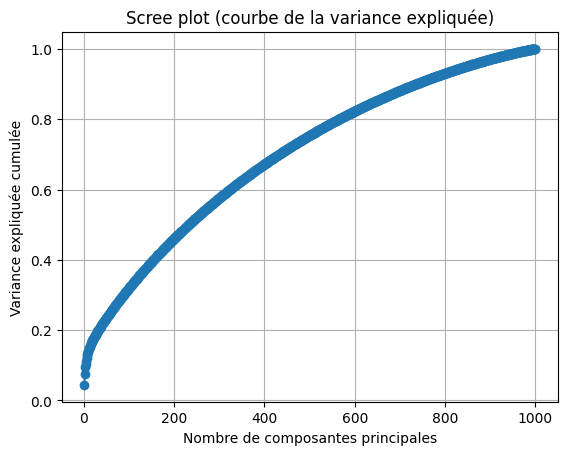

# A first (naive) try at the challenge
We now show a first naive attempt at the challenge, and will proceed in two steps :

    1. First, we will construct a classifier step-by-step. 
    2. Then, we will show how to implement this classifier as a proper RAMP submision.
## Step-by-step construction of a classifier

Given the high-dimensional nature of the problem we will construct a classifier: standardize data, do a PCA retaining only the 50 first components, and finally fit a random forest classifier on the 50 first components.

This can be easily implemented as a scikit-learn `Pipeline`.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


random_forest_pipe = Pipeline(
    [
        #("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 50 components", PCA(n_components=60)),
        (
            "Random Forest Classifier",
            RandomForestClassifier(
                max_depth=75, n_estimators=200, max_features=15
            ),
        ),
    ]
)

random_forest_pipe

Pipeline(steps=[('PCA with 50 components', PCA(n_components=60)),
                ('Random Forest Classifier',
                 RandomForestClassifier(max_depth=75, max_features=15,
                                        n_estimators=200))])

In [ ]:
# Count the number of samples in X_train_norm
n_samples = X_train_norm.shape[0]
print(f"Number of samples in X_train_norm: {n_samples}")

Number of samples in X_train_norm: 1000


In [ ]:
from sklearn.svm import LinearSVC

# Create a Linear SVC pipeline
linear_svc_pipe = Pipeline(
    [
        #("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA", PCA(n_components=60)),
        ("Linear SVC", LinearSVC(max_iter=200000, random_state=42)),
    ]
)
linear_svc_pipe


Pipeline(steps=[('PCA', PCA(n_components=60)),
                ('Linear SVC', LinearSVC(max_iter=200000, random_state=42))])

In [ ]:
# fit on train
pipe = linear_svc_pipe
pipe.fit(X_train_norm, y_train)
y_tr_pred = pipe.predict(X_train_norm)

# predict on test

X_test = X_test[:, kept_genes_idx]
X_test_norm = preprocess_X(X_test, method=preprocessing_method)
y_te_pred = pipe.predict(X_test_norm)


Train balanced accuracy : 0.901
Test balanced accuracy : 0.800


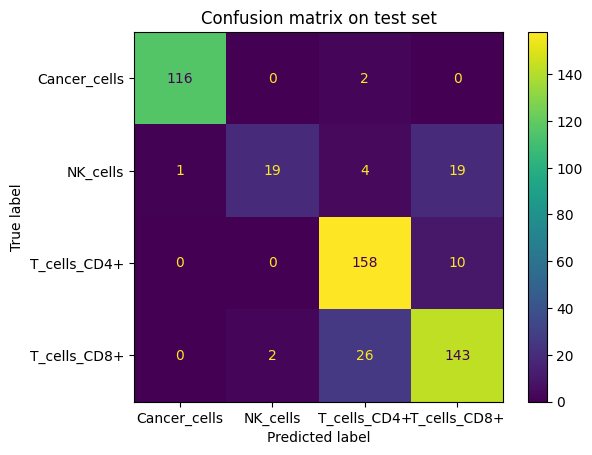

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Build pipeline: reduce dimensionality then KNN
knn_pipe = Pipeline([
    ("PCA", PCA(n_components=60)),
    ("KNN", KNeighborsClassifier(n_neighbors=20, n_jobs=-1)),
])

knn_pipe

Pipeline(steps=[('PCA', PCA(n_components=60)),
                ('KNN', KNeighborsClassifier(n_jobs=-1, n_neighbors=20))])

KNN test balanced accuracy: 0.690


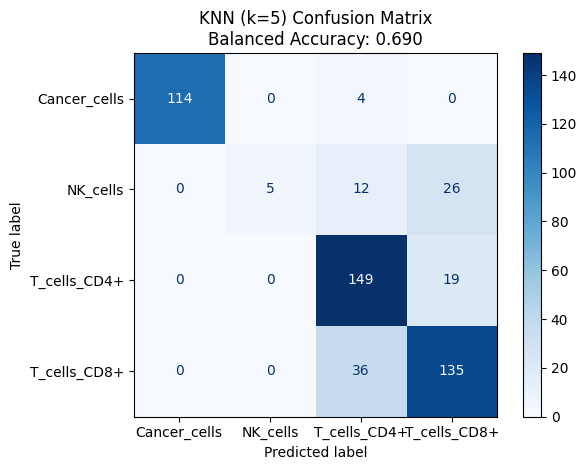

In [ ]:


# Fit on normalized training data (uses X_train_norm, y_train already in the notebook)
knn_pipe.fit(X_train_norm, y_train)

# Predict on test set
y_pred_knn = knn_pipe.predict(X_test_norm)

# Evaluate
bal_acc = balanced_accuracy_score(y_test, y_pred_knn)
print(f"KNN test balanced accuracy: {bal_acc:.3f}")

# Confusion matrix
labels_order = knn_pipe.named_steps["KNN"].classes_
cm = confusion_matrix(y_test, y_pred_knn, labels=labels_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(cmap="Blues", values_format='d')
plt.title(f"KNN (k=5) Confusion Matrix\nBalanced Accuracy: {bal_acc:.3f}")
plt.tight_layout()
plt.show()

Fitting SVC + PCA pipeline...
Making predictions...
SVC test balanced accuracy: 0.795
Making predictions...
SVC test balanced accuracy: 0.795


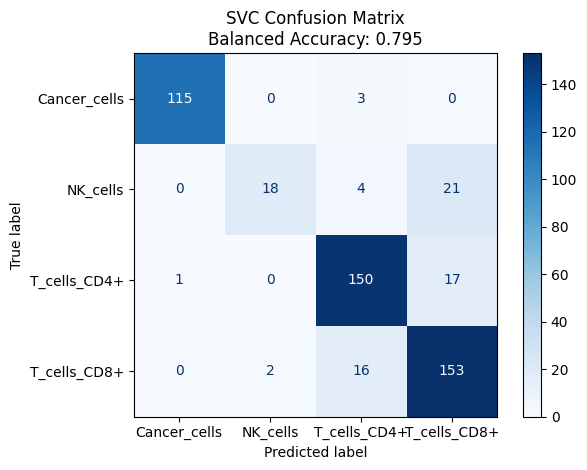

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Build pipeline: reduce dimensionality then SVC
svc_pipe = Pipeline([
    ("PCA", PCA(n_components=60)),
    ("SVC", SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)),
])

# Fit on normalized training data
print("Fitting SVC + PCA pipeline...")
svc_pipe.fit(X_train_norm, y_train)

# Make predictions
print("Making predictions...")
y_pred_svc = svc_pipe.predict(X_test_norm)

# Evaluate
bal_acc = balanced_accuracy_score(y_test, y_pred_svc)
print(f"SVC test balanced accuracy: {bal_acc:.3f}")

# Confusion matrix
labels_order = svc_pipe.named_steps["SVC"].classes_
cm = confusion_matrix(y_test, y_pred_svc, labels=labels_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(cmap="Blues", values_format='d')
plt.title(f"SVC Confusion Matrix\nBalanced Accuracy: {bal_acc:.3f}")
plt.tight_layout()
plt.show()

Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.811
Stacking (LR) balanced accuracy: 0.811


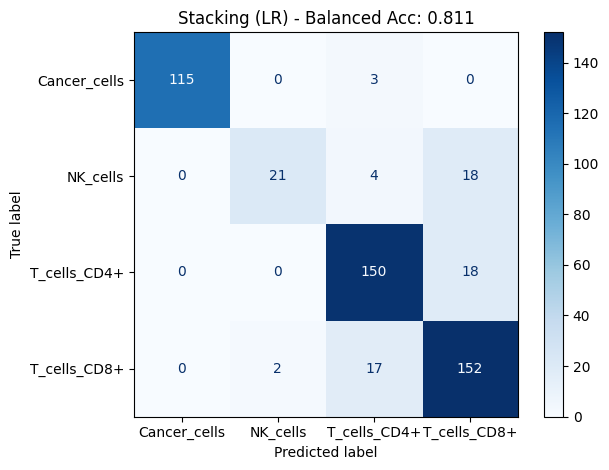

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Ensemble classifiers (Voting + Stacking) on PCA-reduced features
# Relies on existing notebook variables: X_train_norm, X_test_norm, y_train, y_test

import matplotlib.pyplot as plt

def fit_eval_ensembles(X_train, X_test, y_train, y_test, pca_n_components=60, random_state=42):
    # encode labels to integers for stacking final estimator
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    # PCA reduction
    pca = PCA(n_components=min(pca_n_components, np.asarray(X_train).shape[1]), random_state=random_state)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # base estimators
    rf = RandomForestClassifier(n_estimators=200, max_depth=50, max_features="sqrt", random_state=random_state)
    svc = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=random_state)
    knn = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)

    # Voting (soft) ensemble
    voting = VotingClassifier(
        estimators=[("rf", rf), ("svc", svc), ("knn", knn)],
        voting="soft",
        n_jobs=-1,
    )

    # Stacking ensemble (uses same base estimators)
    stacking = StackingClassifier(
        estimators=[("rf", rf), ("svc", svc), ("knn", knn)],
        final_estimator=LogisticRegression(max_iter=2000, solver="lbfgs"),
        n_jobs=-1,
        passthrough=False,
    )

    ensembles = {
        #"Voting (soft)": voting, 
        "Stacking (LR)": stacking}

    results = {}
    for name, clf in ensembles.items():
        print(f"Fitting {name} ...")
        clf.fit(X_train_pca, y_train_enc)
        y_pred_enc = clf.predict(X_test_pca)
        y_pred = le.inverse_transform(y_pred_enc)
        bal = balanced_accuracy_score(y_test, y_pred)
        results[name] = {"bal_acc": bal, "clf": clf, "y_pred": y_pred}
        print(f"{name} balanced accuracy: {bal:.3f}")

        # confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
        disp.plot(cmap="Blues", values_format='d')
        plt.title(f"{name} - Balanced Acc: {bal:.3f}")
        plt.tight_layout()
        plt.show()

    return results, pca, le

# Run ensembles (uses X_train_norm / X_test_norm already defined in the notebook)
results, pca_model_ens, label_encoder_ens = fit_eval_ensembles(
    X_train_norm, X_test_norm, y_train, y_test, pca_n_components=60
)

# Training a classifier for Cancer_cells - NK_cells + T_cells_CD8+ - T_cells_CD4+

## Adaptation du dataset, merge des classes 1 et 3

In [ ]:
# create copies of the normalized feature matrices
X_train_norm_merged = X_train_norm.copy()
X_test_norm_merged = X_test_norm.copy()

# merge classes 1 and 3 (NK_cells and T_cells_CD8+ according to current categories)
merge_from = {"NK_cells", "T_cells_CD8+"}
new_label = "NK_or_T_cells_CD8+"

# convert categorical labels to string arrays and replace
y_train_arr = np.array(y_train).astype(str).copy()
y_test_arr = np.array(y_test).astype(str).copy()

y_train_merged = y_train_arr.copy()
y_train_merged[np.isin(y_train_merged, list(merge_from))] = new_label

y_test_merged = y_test_arr.copy()
y_test_merged[np.isin(y_test_merged, list(merge_from))] = new_label

# convert back to pandas Categorical (keep behavior similar to original y variables)
y_train_merged = pd.Categorical(y_train_merged)
y_test_merged = pd.Categorical(y_test_merged)

# quick check
print("Train label distribution:\n", pd.Series(y_train_merged).value_counts())
print("Test label distribution:\n", pd.Series(y_test_merged).value_counts())

Train label distribution:
 NK_or_T_cell    427
T_cells_CD4+    336
Cancer_cells    237
Name: count, dtype: int64
Test label distribution:
 NK_or_T_cell    214
T_cells_CD4+    168
Cancer_cells    118
Name: count, dtype: int64


Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.924
Stacking (LR) balanced accuracy: 0.924


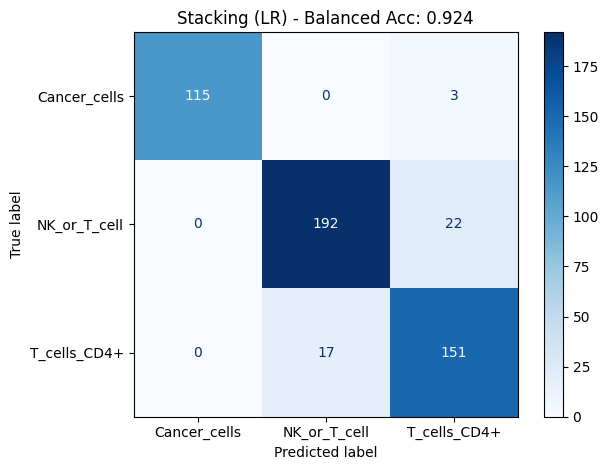

In [ ]:
results_merge, pca_model_merge, label_encoder_merge = fit_eval_ensembles(
    X_train_norm_merged, X_test_norm_merged, y_train_merged, y_test_merged, pca_n_components=60
)

In [ ]:
# Create new copies of normalized feature matrices
X_train_norm_binary = X_train_norm.copy()
X_test_norm_binary = X_test_norm.copy()

# Only conserve NK_cells and T_cells_CD8+ in train/test labels
binary_classes = {"NK_cells", "T_cells_CD8+"}

# Convert categorical labels to string arrays
y_train_arr_bin = np.array(y_train).astype(str).copy()
y_test_arr_bin = np.array(y_test).astype(str).copy()

# Filter indices for binary classification
train_idx_bin = np.isin(y_train_arr_bin, list(binary_classes))
test_idx_bin = np.isin(y_test_arr_bin, list(binary_classes))

# Filter features and labels
X_train_norm_bin = X_train_norm_binary[train_idx_bin]
X_test_norm_bin = X_test_norm_binary[test_idx_bin]
y_train_bin = y_train_arr_bin[train_idx_bin]
y_test_bin = y_test_arr_bin[test_idx_bin]

# Convert to pandas Categorical for compatibility
y_train_bin = pd.Categorical(y_train_bin)
y_test_bin = pd.Categorical(y_test_bin)

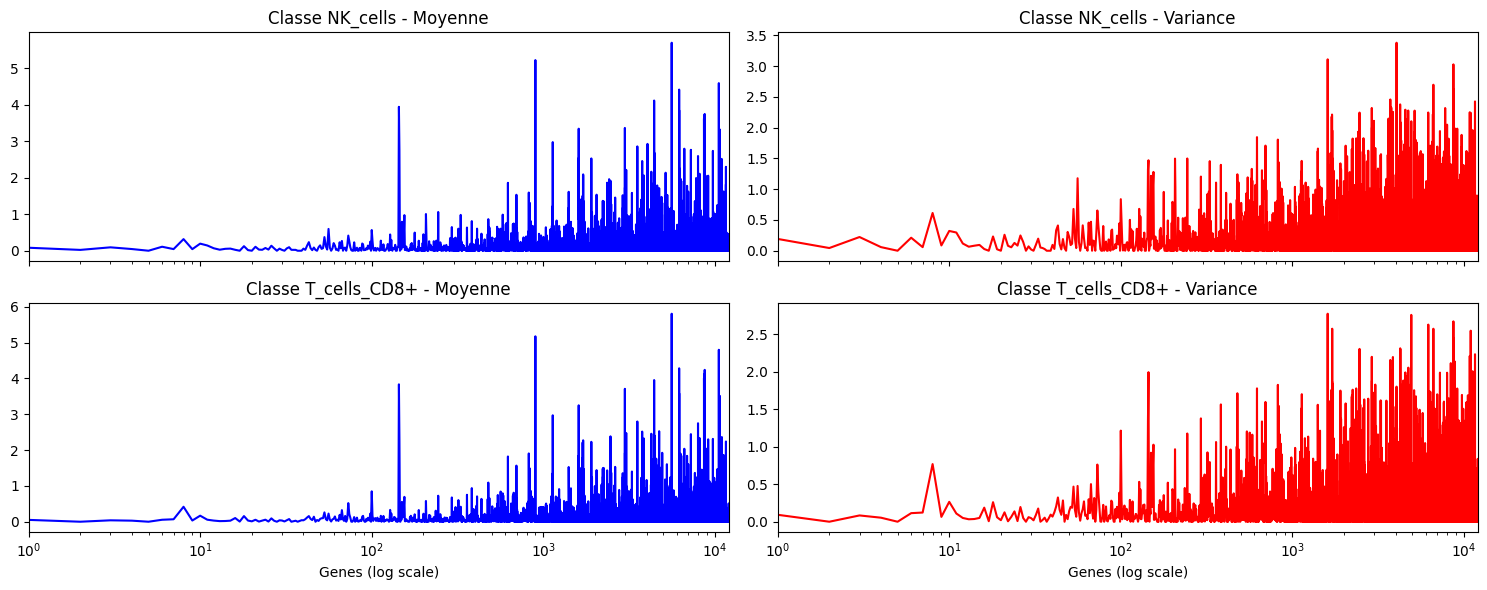

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

binary_classes = np.unique(y_train_bin)
n_classes_bin = len(binary_classes)
n_genes_bin = X_train_norm_bin.shape[1]

fig, axes = plt.subplots(n_classes_bin, 2, figsize=(15, 3 * n_classes_bin), sharex=True)

for idx, cls in enumerate(binary_classes):
    gene_values = X_train_norm_bin[np.array(y_train_bin) == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convert sparse -> dense if needed
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes_bin])

    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes_bin])

for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()



We keep only high expressed genes

In [ ]:
from scipy.sparse import issparse

# Remove low expressed genes using variance threshold 0.2

X_train_bin_filtered, kept_genes_bin_idx = remove_genes(X_train_norm_bin, threshold=1.2)
X_test_bin_filtered = X_test_norm_bin[:, kept_genes_bin_idx]

print(f"Filtered X_train_bin shape: {X_train_bin_filtered.shape}")
print(f"Filtered X_test_bin shape: {X_test_bin_filtered.shape}")

Filtered X_train_bin shape: (427, 292)
Filtered X_test_bin shape: (214, 292)


Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.837
Stacking (LR) balanced accuracy: 0.837


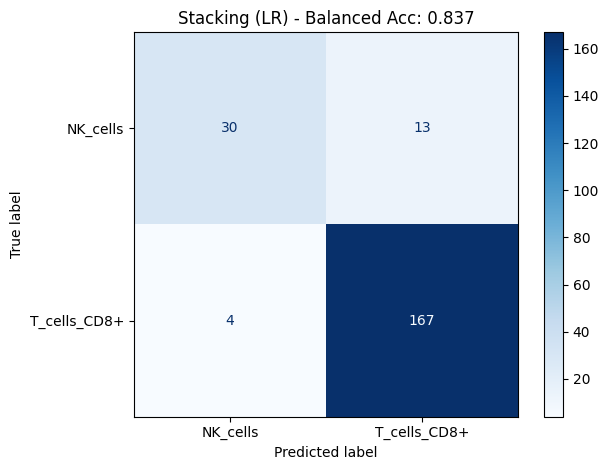

In [ ]:

# Train and predict using the previous ensemble function
results_bin, pca_model_bin, label_encoder_bin = fit_eval_ensembles(
    X_train_bin_filtered, X_test_bin_filtered, y_train_bin, y_test_bin, pca_n_components=0.8
)

Test balanced accuracy (two-stage): 0.856


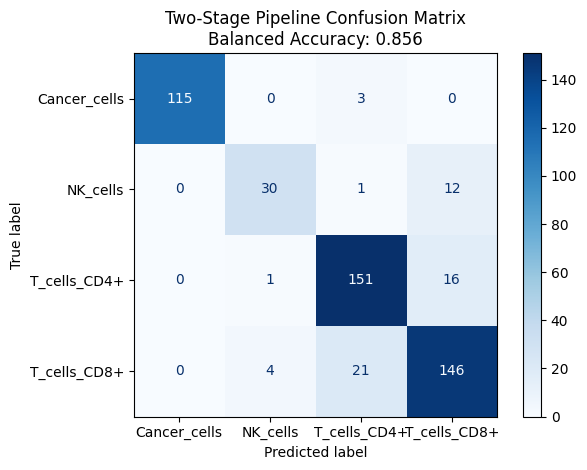

In [ ]:
# Two-stage prediction pipeline
# Stage 1: Predict using merged model (3 classes)
# Stage 2: If prediction is NK_or_T_cell, refine with binary model

# Get PCA-reduced test data for merged model
X_test_pca_merge = pca_model_merge.transform(X_test_norm)

# Stage 1: Predict with merged classifier
y_pred_stage1 = results_merge["Stacking (LR)"]["clf"].predict(X_test_pca_merge)
y_pred_stage1 = label_encoder_merge.inverse_transform(y_pred_stage1)

# Stage 2: Refine NK_or_T_cell predictions with binary model
y_pred_final = y_pred_stage1.copy()

# Find indices where stage 1 predicted NK_or_T_cell
nk_or_t_mask = y_pred_stage1 == "NK_or_T_cell"

if nk_or_t_mask.sum() > 0:
    # Get the samples predicted as NK_or_T_cell
    X_test_bin = X_test[nk_or_t_mask]
    X_test_bin_norm = preprocess_X(X_test_bin, method=preprocessing_method)
    
    # CRITICAL FIX: Use the same gene indices from binary training
    # Apply the filtering used during binary model training
    X_test_bin_filtered = X_test_bin_norm[:, kept_genes_bin_idx]
    
    # Predict with binary model
    X_test_pca_bin = pca_model_bin.transform(X_test_bin_filtered)
    y_pred_bin_enc = results_bin["Stacking (LR)"]["clf"].predict(X_test_pca_bin)
    y_pred_bin = label_encoder_bin.inverse_transform(y_pred_bin_enc)
    
    # Update final predictions for NK_or_T_cell samples
    y_pred_final[nk_or_t_mask] = y_pred_bin

# Evaluate
print(f"Test balanced accuracy (two-stage): {balanced_accuracy_score(y_test, y_pred_final):.3f}")

# Confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=np.unique(y_test))
disp_final.plot(cmap="Blues", values_format='d')
plt.title(f"Two-Stage Pipeline Confusion Matrix\nBalanced Accuracy: {balanced_accuracy_score(y_test, y_pred_final):.3f}")
plt.tight_layout()
plt.show()

This naive classifier does a better job than a dummy random classifier which would yield an average balanced accuracy of 1/4. 
However, it never predicts the "NK_cell" type and seems to confuse between the two different "T-cell" types. There seems to be room for improvement. Good news, it is your job ! :)

Next, let's see how to implement this exact same classifier as a receivable RAMP submission

## Designing the RAMP submission
The RAMP challenge is automatized and a submission requires a specific structure described below.


### Mandatory structure of a submission


A submission is stored in `./submissions/<submission_foldername>/` and must contain a Python file named `classifier.py`.

This python script must itself implement (at least) a custom `Classifier` class with
 * A `fit(X, y)` method.
 * A `predict_proba(X)` method.
 
**Warning**: the `X` argument must be understood as the sparse CSR count data matrix obtained by `get_train_data()`. Thus any pre-processing of the count matrix must be done inside the methods.

We illustrate this below with the naive classifier already implemented.

### Illustration with the naive classifier

> Note: The following class is also implemented in `./submissions/starting_kit/classifier.py`.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.sparse import issparse


def remove_genes(X, threshold=0.01):
    """
    Supprime les gènes dont la variance est inférieure à un seuil.

    Args:
        X (np.ndarray ou csr_matrix): matrice cellules x gènes
        threshold (float): seuil minimal de variance

    Returns:
        X_filtered: matrice filtrée (mêmes type que X)
        kept_idx: indices des gènes conservés
    """
    if issparse(X):
        # variance = mean(x^2) - mean(x)^2
        mean = np.array(X.mean(axis=0)).ravel()
        mean_sq = np.array(X.multiply(X).mean(axis=0)).ravel()
        var = mean_sq - mean**2
    else:
        var = X.var(axis=0)

    # indices des gènes à garder
    kept_idx = np.where(var >= threshold)[0]

    # filtrer X
    if issparse(X):
        X_filtered = X[:, kept_idx]
    else:
        X_filtered = X[:, kept_idx]

    return X_filtered, kept_idx


class Classifier(object):
    def __init__(self):
        # Label encoders for both stages
        self.le_merge = LabelEncoder()  # For 3-class merged model
        self.le_bin = LabelEncoder()    # For binary NK/T-CD8+ model
        
        # Gene filtering indices
        self.kept_idx_merge = None  # For merged model
        self.kept_idx_bin = None    # For binary model
        
        # Stage 1: Merged model (3 classes: B_cells, Monocytes, NK_or_T_cell)
        rf_merge = RandomForestClassifier(n_estimators=200, max_depth=50,
                                         max_features="sqrt", random_state=42)
        svc_merge = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale",
                       random_state=42)
        knn_merge = KNeighborsClassifier(n_neighbors=15)
        
        stack_merge = StackingClassifier(
            estimators=[("rf", rf_merge), ("svc", svc_merge), ("knn", knn_merge)],
            final_estimator=LogisticRegression(max_iter=10000, solver="lbfgs"),
            n_jobs=-1,
            passthrough=False
        )
        
        self.pipe_merge = make_pipeline(
            PCA(n_components=60, random_state=42),
            stack_merge
        )
        
        # Stage 2: Binary model (NK_cells vs T_cells_CD8+)
        rf_bin = RandomForestClassifier(n_estimators=200, max_depth=50,
                                       max_features="sqrt", random_state=42)
        svc_bin = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale",
                     random_state=42)
        knn_bin = KNeighborsClassifier(n_neighbors=15)
        
        stack_bin = StackingClassifier(
            estimators=[("rf", rf_bin), ("svc", svc_bin), ("knn", knn_bin)],
            final_estimator=LogisticRegression(max_iter=10000, solver="lbfgs"),
            n_jobs=-1,
            passthrough=False
        )
        
        self.pipe_bin = make_pipeline(
            PCA(n_components=0.8, random_state=42),  # 80% variance
            stack_bin
        )

    def _preprocess_X(self, X, fit=False, kept_idx=None, threshold=0.01):
        """
        Preprocess features: filter genes + library size normalization + log1p
        """
        # Convert sparse to dense if needed
        if issparse(X):
            X = X.toarray()
        
        # Gene filtering
        if fit:
            X_filtered, kept_idx = remove_genes(X, threshold=threshold)
            return_idx = kept_idx
        else:
            if kept_idx is None:
                raise ValueError("kept_idx must be provided when fit=False")
            X_filtered = X[:, kept_idx]
            return_idx = None
        
        # Library size normalization + log1p
        libsize = X_filtered.sum(axis=1)[:, None]
        libsize[libsize == 0] = 1
        X_processed = np.log1p(X_filtered / libsize * 1e4)
        
        if fit:
            return X_processed, return_idx
        else:
            return X_processed

    def fit(self, X_sparse, y):
        """
        Train the two-stage classifier
        
        Stage 1: Train merged model (3 classes)
        Stage 2: Train binary model (NK_cells vs T_cells_CD8+)
        """
        # Convert y to numpy array
        y_arr = np.array(y).astype(str)
        
        # ===== STAGE 1: Merged Model (3 classes) =====
        # Merge NK_cells and T_cells_CD8+ into one class
        merge_from = {"NK_cells", "T_cells_CD8+"}
        self.merged_label = "NK_or_T_cell"  # Store the merged label name
        
        y_merged = y_arr.copy()
        y_merged[np.isin(y_merged, list(merge_from))] = self.merged_label
        
        # Preprocess and fit merged model
        X_merge, self.kept_idx_merge = self._preprocess_X(X_sparse, fit=True, threshold=0.01)
        y_merge_enc = self.le_merge.fit_transform(y_merged)
        self.pipe_merge.fit(X_merge, y_merge_enc)
        
        # ===== STAGE 2: Binary Model (NK_cells vs T_cells_CD8+) =====
        # Filter to only NK_cells and T_cells_CD8+
        binary_classes = {"NK_cells", "T_cells_CD8+"}
        bin_mask = np.isin(y_arr, list(binary_classes))
        
        X_bin = X_sparse[bin_mask] if issparse(X_sparse) else X_sparse[bin_mask]
        y_bin = y_arr[bin_mask]
        
        # Preprocess with higher variance threshold for binary model
        X_bin_processed, self.kept_idx_bin = self._preprocess_X(X_bin, fit=True, threshold=1.2)
        y_bin_enc = self.le_bin.fit_transform(y_bin)
        self.pipe_bin.fit(X_bin_processed, y_bin_enc)
        
        # Store original classes for compatibility
        self.classes_ = np.unique(y_arr)
        
        # Create mapping from class names to indices
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes_)}

    def predict_proba(self, X_sparse):
        """
        Two-stage prediction:
        1. Predict with merged model (3 classes)
        2. If predicted as NK_or_T_cell, refine with binary model
        """
        n_samples = X_sparse.shape[0]
        n_classes = len(self.classes_)
        
        # Initialize probability matrix
        proba_final = np.zeros((n_samples, n_classes))
        
        # ===== STAGE 1: Predict with merged model =====
        X_merge = self._preprocess_X(X_sparse, fit=False, kept_idx=self.kept_idx_merge)
        proba_merge = self.pipe_merge.predict_proba(X_merge)
        y_pred_merge_enc = self.pipe_merge.predict(X_merge)
        y_pred_merge = self.le_merge.inverse_transform(y_pred_merge_enc)
        
        # ===== STAGE 2: Process predictions =====
        nk_or_t_mask = y_pred_merge == self.merged_label
        
        # For samples NOT predicted as merged class
        for i in np.where(~nk_or_t_mask)[0]:
            pred_label = y_pred_merge[i]
            class_idx = self.class_to_idx[pred_label]
            # Use probabilities from merged model
            merge_class_idx = self.le_merge.transform([pred_label])[0]
            proba_final[i, class_idx] = proba_merge[i, merge_class_idx]
        
        # For samples predicted as merged class, refine with binary model
        if nk_or_t_mask.sum() > 0:
            # Get samples predicted as merged class
            X_bin = X_sparse[nk_or_t_mask] if issparse(X_sparse) else X_sparse[nk_or_t_mask]
            
            # Preprocess with binary model's gene filtering
            X_bin_processed = self._preprocess_X(X_bin, fit=False, kept_idx=self.kept_idx_bin)
            
            # Predict with binary model
            proba_bin = self.pipe_bin.predict_proba(X_bin_processed)
            
            # Map binary probabilities to final matrix
            bin_classes = self.le_bin.classes_
            nk_or_t_indices = np.where(nk_or_t_mask)[0]
            
            for j, sample_idx in enumerate(nk_or_t_indices):
                for k, bin_class in enumerate(bin_classes):
                    class_idx = self.class_to_idx[bin_class]
                    proba_final[sample_idx, class_idx] = proba_bin[j, k]
        
        return proba_final

Below is a simplified version of what RAMP does with your submission.

In [ ]:
clf = Classifier()
clf.fit(X_train, y_train)
# predict_proba 
y_tr_pred_proba = clf.predict_proba(X_train)
X_test = X_test[:, kept_genes_idx]
y_te_pred_proba = clf.predict_proba(X_test)

# convert to hard classification with argmax
y_tr_pred = clf.classes_[np.argmax(y_tr_pred_proba, axis=1)]
y_te_pred = clf.classes_[np.argmax(y_te_pred_proba, axis=1)]

In [ ]:
print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

Train balanced accuracy: 0.9113120023159165
Test balanced accuracy: 0.7100136752174748


In reality things are a bit more sophisticated. **Locally**, the RAMP platform averages your classifier preformance over a 5-fold cross-validation scheme implemented for you in the `get_cv` method. The good news is, RAMP automatize everything for you thanks to `ramp-test`. The public train, validation and test performance are shown to you for information. 


<div class="alert alert-block alert-info">
<b>A note on hyper-parameter search</b> RAMP does not perform hyper-parameter tuning, nor grid-search for you. You need to implement this locally, on your own machine, and fix the hyper-parameters by hand in your Classifier class when sending your submission. Another option is to use K-fold cross-validation in the `fit()` method of your classifier, but it could lead to heavy computation times that would delay your research. </a>.
</div> 



### Submitting to RAMP

Before submitting to RAMP, you can test your solution locally to ensure that trivial errors (e.g. typos, path issues, etc.) are resolved. We can test a given submission using the `ramp-test` command that was installed in the virtual environment.  

We'll use the following command:  

`!ramp-test --submission <subm_folder> --quick-test` 

The `!` signals that the command should be run on the command line instead of this notebook.  
`ramp-test` is the command to be executed. It signals ramp to perform a local test. 

`--submission <subm_folder>` specifies which submission to run. You can have multiple potential submissions in the `submissions/` directory; this prevents `ramp` from running all of them (and by default it runs starting_kit).  

In [ ]:
!ramp-test --submission test

Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/test ...
CV fold 0
	score  bal_acc       time
	train     0.97  21.326219
	valid     0.89   1.170499
	test      0.85   0.977104
CV fold 1
	score  bal_acc       time
	train     0.98  17.849974
	valid     0.88   0.870459
	test      0.85   0.994390
CV fold 2
	score  bal_acc       time
	train     0.97  18.922778
	valid     0.89   2.676856
	test      0.84   1.393699
CV fold 3
	score  bal_acc       time
	train     0.97  18.812542
	valid     0.92   1.313597
	test      0.87   1.523322
CV fold 4
	score  bal_acc       time
	train     0.97  20.136401
	valid     0.86   0.964355
	test      0.84   0.915814
----------------------------
Mean CV scores
----------------------------
	score       bal_acc        time
	train  0.98 ± 0.003  19.4 ± 1.2
	valid  0.89 ± 0.018  1.4 ± 0.66
	test   0.85 ± 0.011  1.2 ± 0.25
----------------------------
Bagged scores
-----------------

We see that the mean CV scores are consistent with the previous result we had. If you use a classifier with more variance, you would see more variation accross CV-folds. 

<div class="alert alert-info"> 
    
<b>Note on style complicance</b> Every `submissions/*.py` files will be checked for style compliance before running on RAMP server. It is done thanks to the [flake8](https://flake8.pycqa.org/en/latest/) package. Before submitting, you need to fix any error raised by the following terminal command
    
`$flake8 submissions/`
<br/>

The **black** auto-formatting tool works very well to automatically format your code accoring to flake8 standard when saving your files in VScode or PyCharm IDEs. 

You might want to check [this page](https://flake8.pycqa.org/en/3.1.1/user/ignoring-errors.html) for ignoring specific errors in some corner-cases. 

</div>

## Ranking & Leaderboard

**On the server**, the participants are ranked according to the balanced accuracy score on the private test data set. However, only the ranking will be available, and not the score in itself in order to avoid overfitting of this private test set. The score on public test will be available as a proxy but your submission could very well have a better ranking on private with a worst balanced accuracy on public. 

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

# Now it's your turn